In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import walk
from os.path import join

In [416]:
def get_files(data_path='data', exclude=['MATIC']):
    files = []
    for (dirpath, dirnames, filenames) in walk(data_path):
        files.extend(filenames)
        break #only top directory
    
    for string in exclude:
        files = [f for f in files if string not in f]
    
    files = [f for f in files if '.csv' in f]

    return files

def get_df_from_file(file, data_path='data', eth_price=None, price_dfs=None):

    def add_meta_data(split, df):
        df.filename = file
        df.fee_size = None
        if split[-1].isdigit():
            df.fee_size = int(split[-1])
            split.pop(-1)

        if split[-1] in ['ng', 'concentrated']:
            split.pop(-1)

        df.name_token1, df.name_token0 = split[-1], split[-2]
        df.chain, df.frequency  = split[-3], split[-4]

        df.amm = split[0]
        if split[0] == 'uniswap':
            df.amm_version = split[1]
        return df

    df = pd.read_csv(join(data_path,file))
    df = df.apply(pd.to_numeric, errors='coerce')
    df['exact_date'] = pd.to_datetime(df['timestamp'],unit='s')
    df['date'] = df['exact_date'].dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'])

    df = enrich_df(df, eth_price)
    
    df = df.dropna().reset_index(drop=True)
    if 'token0Balance' in df.columns:
        df.rename(columns={'token0Balance': 'token0BalancePostion', 'token1Balance': 'token1BalancePostion'}, inplace=True)
    split = file.rstrip('.csv').split('_')

    df = add_meta_data(split, df)
    df = add_yahoo_price_data(df, price_dfs)
    df = df.dropna().reset_index(drop=True)
    df = add_meta_data(split, df)
  

    return df


def enrich_df(df, eth_price, col='Close'):
    df = df.merge(eth_price[['date',col]], on='date', how='left')
    df = df.rename(columns={col: 'eth_price'})
    return df

def get_yahoo_price_data(files, data_path='price_data'):
    price_dfs = []
    for file in files:
        df = pd.read_csv(join(data_path,file))
        df['date'] = pd.to_datetime(df['Date'])
        df.name_token = file.rstrip('.csv').split('-')[0]
        price_dfs.append(df)
        
    return price_dfs
        
def add_yahoo_price_data(df, price_dfs, col='Close'):
    token0 = df.name_token0
    token1 = df.name_token1

    for p_df in price_dfs:
        print(type(p_df))
        if token0.lower() == p_df.name_token.lower(): 
            df = df.merge(p_df[['date',col]], on='date', how='left')
            df = df.rename(columns={col: 'token0_yahoo_price'})
        if token1.lower() == p_df.name_token.lower():
            df = df.merge(p_df[['date',col]], on='date', how='left')
            df = df.rename(columns={col: 'token1_yahoo_price'})
    return df


In [417]:
def calculate_hodl(df, rebase_value):

    #calculate rebase adjustment
    a = np.full((len(df),), (1+rebase_value)**(1/365))
    a[0]=1
    df['rebase_adjustment']=a
    df['rebase_adjustment']=df['rebase_adjustment'].cumprod()

    #calculate worth of token0
    df['token0_position_value']= df['token0BalancePostion']*df['token0PriceUSD']
    df['token0_position_value_rebase_adjusted']=df['token0_position_value']*df['rebase_adjustment']

    #calculate worth of token1
    df['token1_position_value']= df['token1BalancePostion']*df['token1PriceUSD']

    



In [418]:
files = get_files()
price_files = get_files(data_path='price_data')
yahoo_data = get_yahoo_price_data(price_files)

eth_price = pd.read_csv('price_data/ETH-USD.csv')
eth_price['date'] = pd.to_datetime(eth_price['Date'])

dfs = [get_df_from_file(f, eth_price=eth_price, price_dfs=yahoo_data) for f in files]
dfs = sorted(dfs, key = lambda x: (x.amm, x.name_token0))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pand

In [362]:
df = dfs[0]

In [493]:
for df in dfs:
    #if df.amm == 'curve':
    rebase_value = 0.05

    a = np.full((len(df),), (1+rebase_value)**(1/365))
    a[0]=1
    df['rebase_adjustment']=a
    df['rebase_adjustment']=df['rebase_adjustment'].cumprod()

    lsd = 'token0'
    weth = 'token1'
    if df.name_token0=="WETH" or df.name_token0=="ETH" :
        lsd = 'token1'
        weth = 'token0'
        
    df[lsd+'_position_value']= df[lsd+'BalancePostion']*df[lsd+'_yahoo_price']
    df[weth+'_position_value']= df[weth+'BalancePostion']*df[weth+'_yahoo_price']

    df[lsd+'hodl_position_value']= df[lsd+'BalancePostion'][0]*df[lsd+'_yahoo_price']
    df[weth+'hodl_position_value']= df[weth+'BalancePostion'][0]*df[weth+'_yahoo_price']
    
    #if rebase = True:
    #    pass
    df['hodl']=df[weth+'hodl_position_value'] + df[lsd+'hodl_position_value']#*df['rebase_adjustment']
    df['hodl']=df['hodl']/df['eth_price']
    df['hodl_normalized'] = df['hodl']/df['hodl'][0]


    df['tvl'] = df[weth+'BalancePostion']*df[weth+'_yahoo_price'] + df[lsd+'BalancePostion']*df[lsd+'_yahoo_price']
    df['tvl_ethnorm'] = df['tvl']/df['eth_price']

    if 'outputTokenSupply' in df.columns:
        df['lp_value'] = df['tvl']/df['outputTokenSupply']
        df['lp_value'] = df['lp_value']/df['eth_price']
        df['lp_value'] = df['lp_value']/df['lp_value'][0]

    else:
        df['lp_value']=df['positionValueETH']/df['positionValueETH'][0]



In [494]:


import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/garrettj403/SciencePlots/master/scienceplots/styles/science.mplstyle')

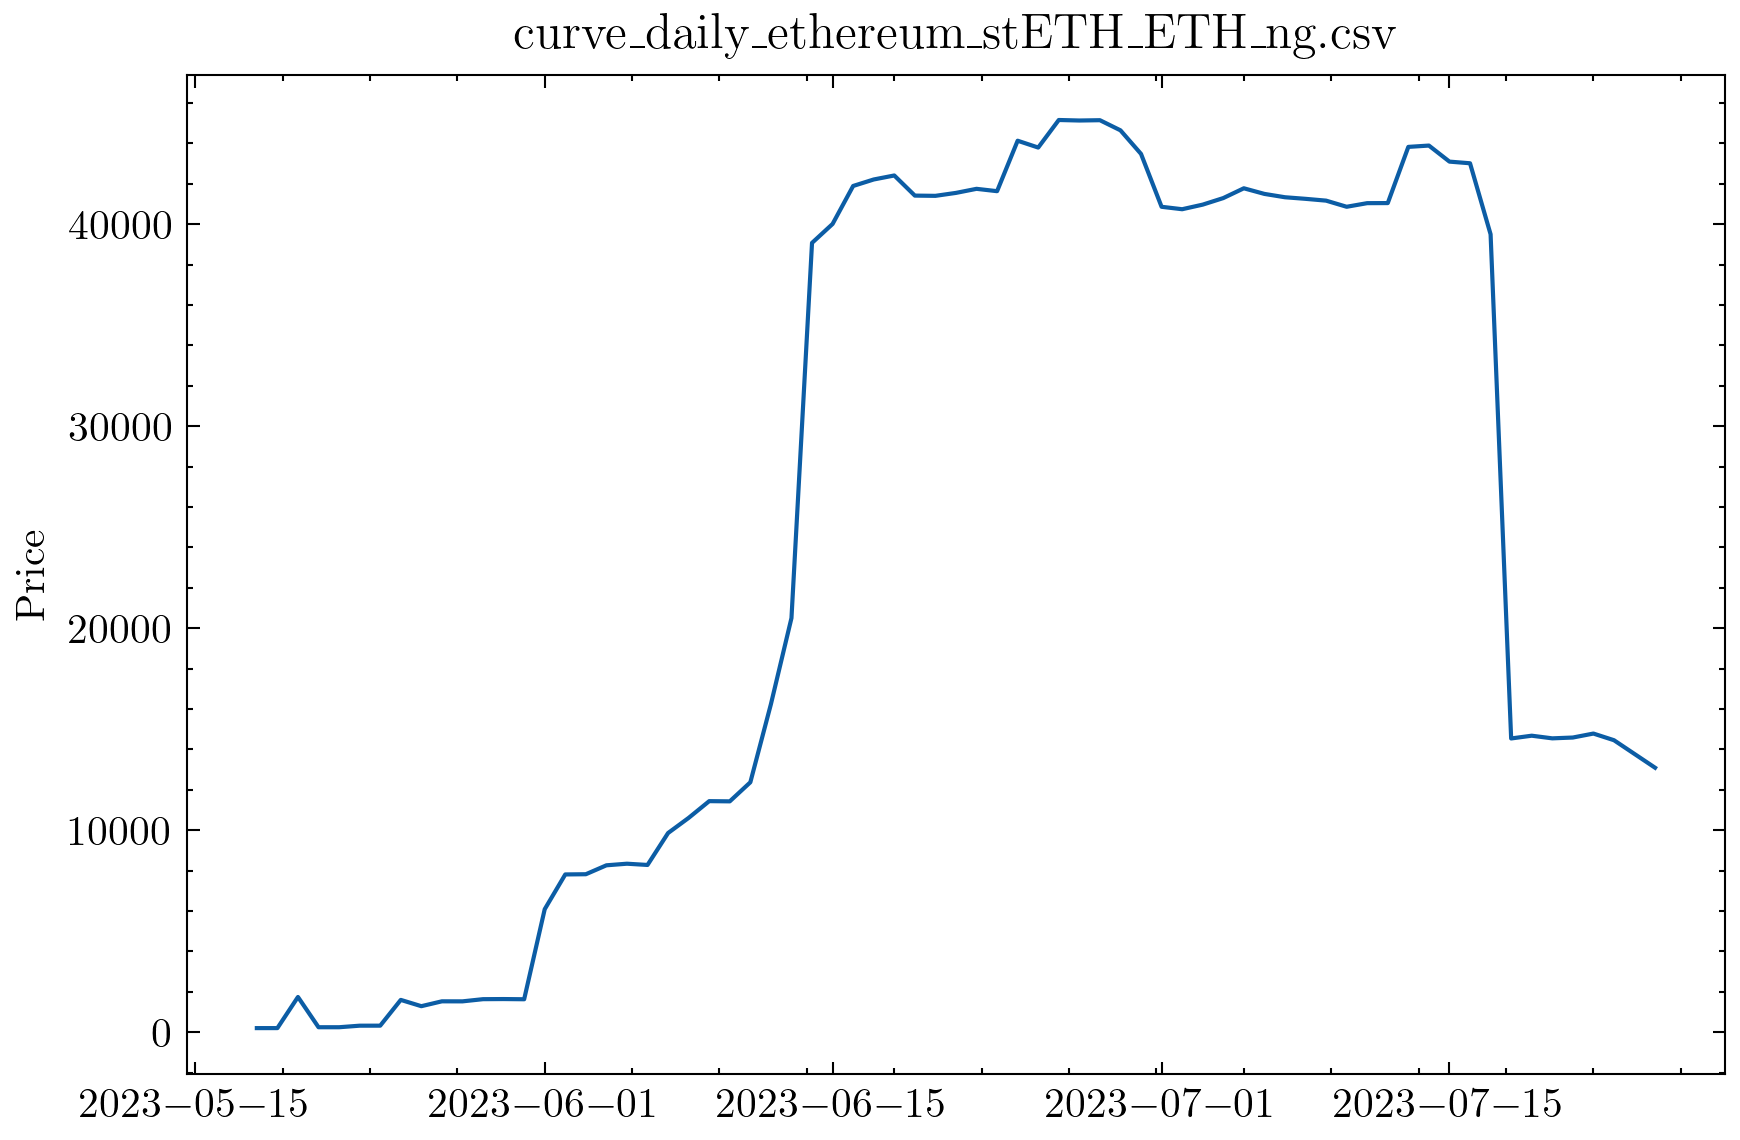

In [495]:
df = dfs[5]
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,4),dpi =300)

ax.plot(df['date'], df['totalValueLockedUSD']/df['eth_price'])

ax.set_title(df.filename)
ax.set_ylabel('Price')

fig.set_facecolor('w')
fig.tight_layout()

#plt.savefig("LST_ETH.svg", facecolor=fig.get_facecolor())

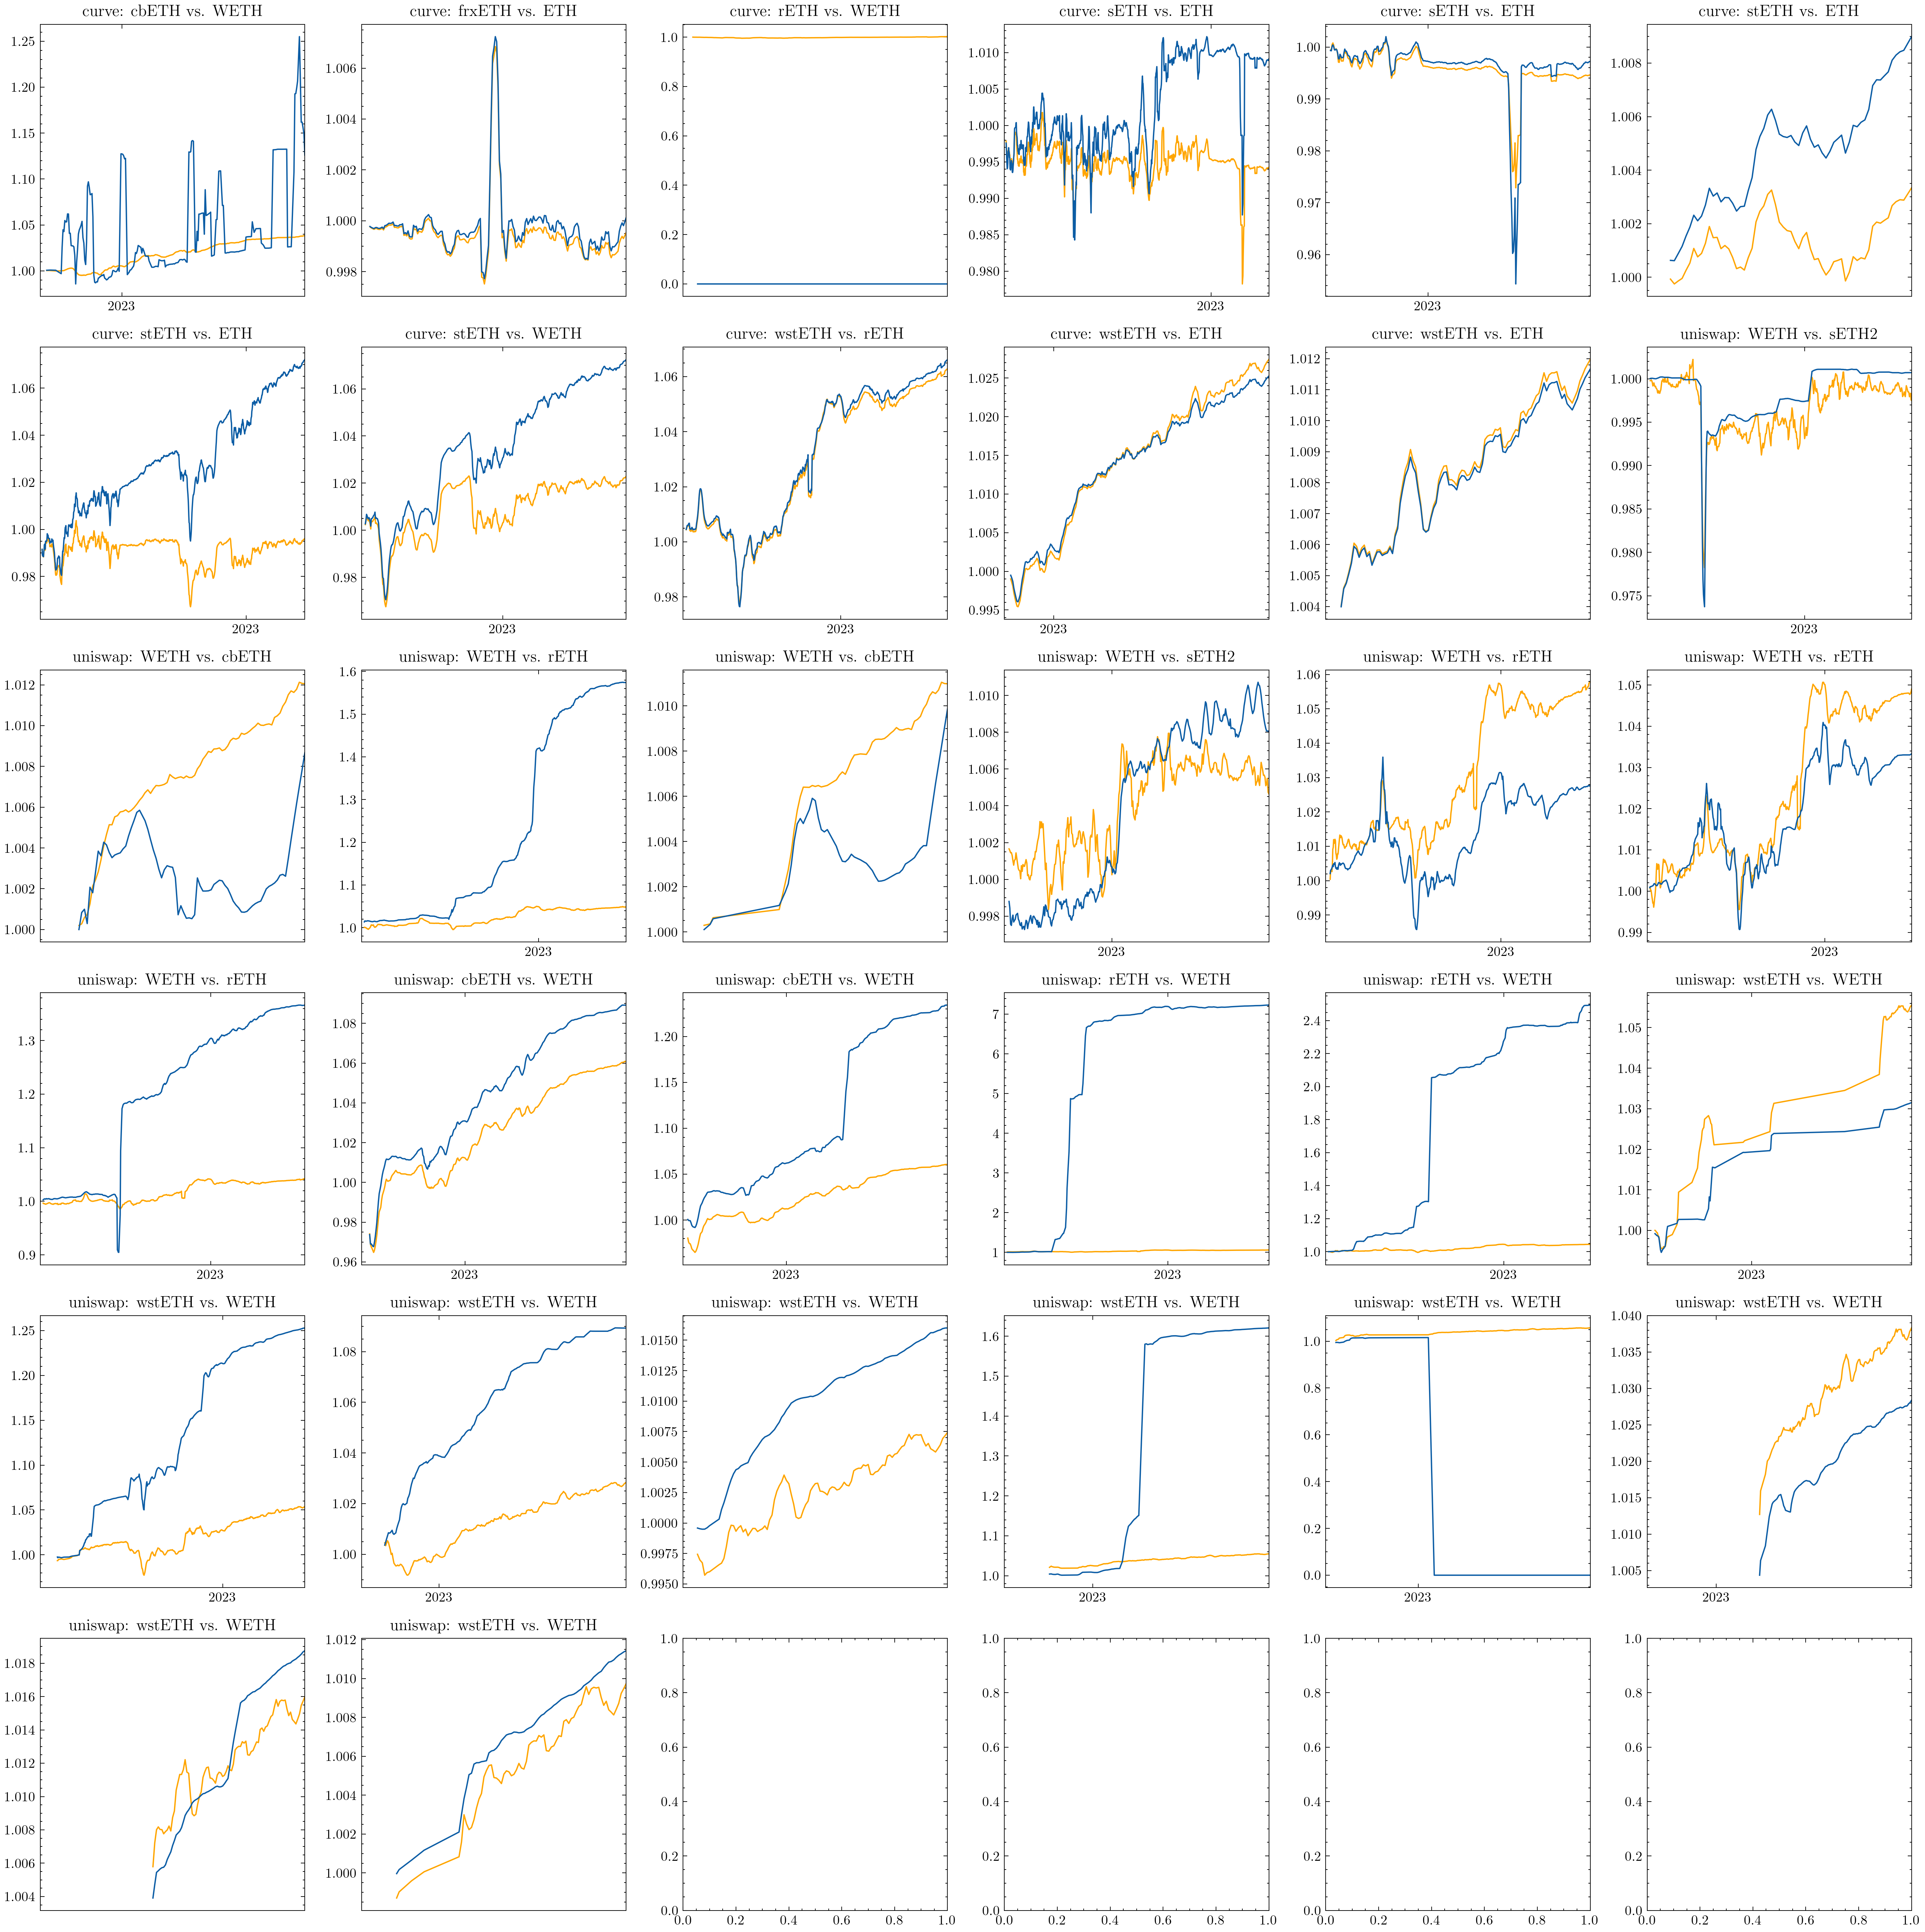

In [496]:
fig, axes = plt.subplots(nrows=6,ncols=6, figsize=(20,20),dpi =300)

formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels




i = 0 
for c in axes:
    for ax in c:
        if i < len(dfs):
            
            ax.plot(dfs[i]['date'], dfs[i]['hodl_normalized'].rolling(7).mean() , color = 'orange')
            ax.plot(dfs[i]['date'], dfs[i]['lp_value'].rolling(7).mean() )



            y  =dfs[i]['lp_value'].rolling(7).mean() - dfs[i]['hodl_normalized'].rolling(7).mean()
            #ax.fill_between(dfs[i]['date'], 0, y, where=y>0, facecolor='black', interpolate=True)
            #ax.fill_between(dfs[i]['date'], 0, y, where=y<=0, facecolor='grey', interpolate=True)

                
            ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
            ax.xaxis.set_major_locator(locator)
            ax.set_xlim(min(dfs[i]['date']),max(dfs[i]['date']))
            #ax.set_ylim(-0.5,0.5)

            ax.set_title(dfs[i].amm + ': ' + dfs[i].name_token0 +' vs. '+ dfs[i].name_token1)


        i +=1



#ax.set_title(df.filename)
#ax.set_ylabel('Price')

fig.set_facecolor('w')
fig.tight_layout()

In [500]:
dfs[1].head(2)

,day,blockNumber,timestamp,totalValueLockedUSD,dailyVolumeUSD,dailySupplySideRevenueUSD,token0BalancePostion,token1BalancePostion,token0PriceUSD,token1PriceUSD,...,rebase_adjustment,token1_position_value,token0_position_value,token1hodl_position_value,token0hodl_position_value,hodl,hodl_normalized,tvl,lp_value,tvl_ethnorm
0,19369,16394119,1673567567,8.283980e+07,396695.799197,79.339160,29502.634281,29936.390273,1385.672628,1401.598603,...,1.000000,4.244796e+07,4.185575e+07,4.244796e+07,4.185575e+07,59455.127387,1.000000,8.430371e+07,1.000000,59455.127387
1,19370,16401232,1673653379,9.202174e+07,10190.307271,2.038061,31965.600053,32628.400240,1444.529400,1405.110000,...,1.000134,4.736387e+07,4.640607e+07,4.345611e+07,4.283046e+07,59441.778417,0.999775,9.376994e+07,0.999776,64596.984056


In [501]:
tvl_frames = []
for df in dfs:
    d = df[['date','tvl_ethnorm']]
    d.name = df.filename
    d = d.rename(columns={'tvl_ethnorm':  df.filename})
    d = d.set_index('date')
    tvl_frames.append(d)

df = tvl_frames[0]
for d in tvl_frames:
    df=pd.merge(df,d, how='outer', left_index=True, right_index=True)

for c in df.columns:
    if np.isnan(df[c][0]):
        df[c][0]=0
    #df = df.set_index('Datetime')
    #df = df.rename(columns={col: 'token1_yahoo_price'})

df.ffill(inplace=True)


stack = np.vstack([df[c]for c in df.columns])
labels = [c for c in df.columns]

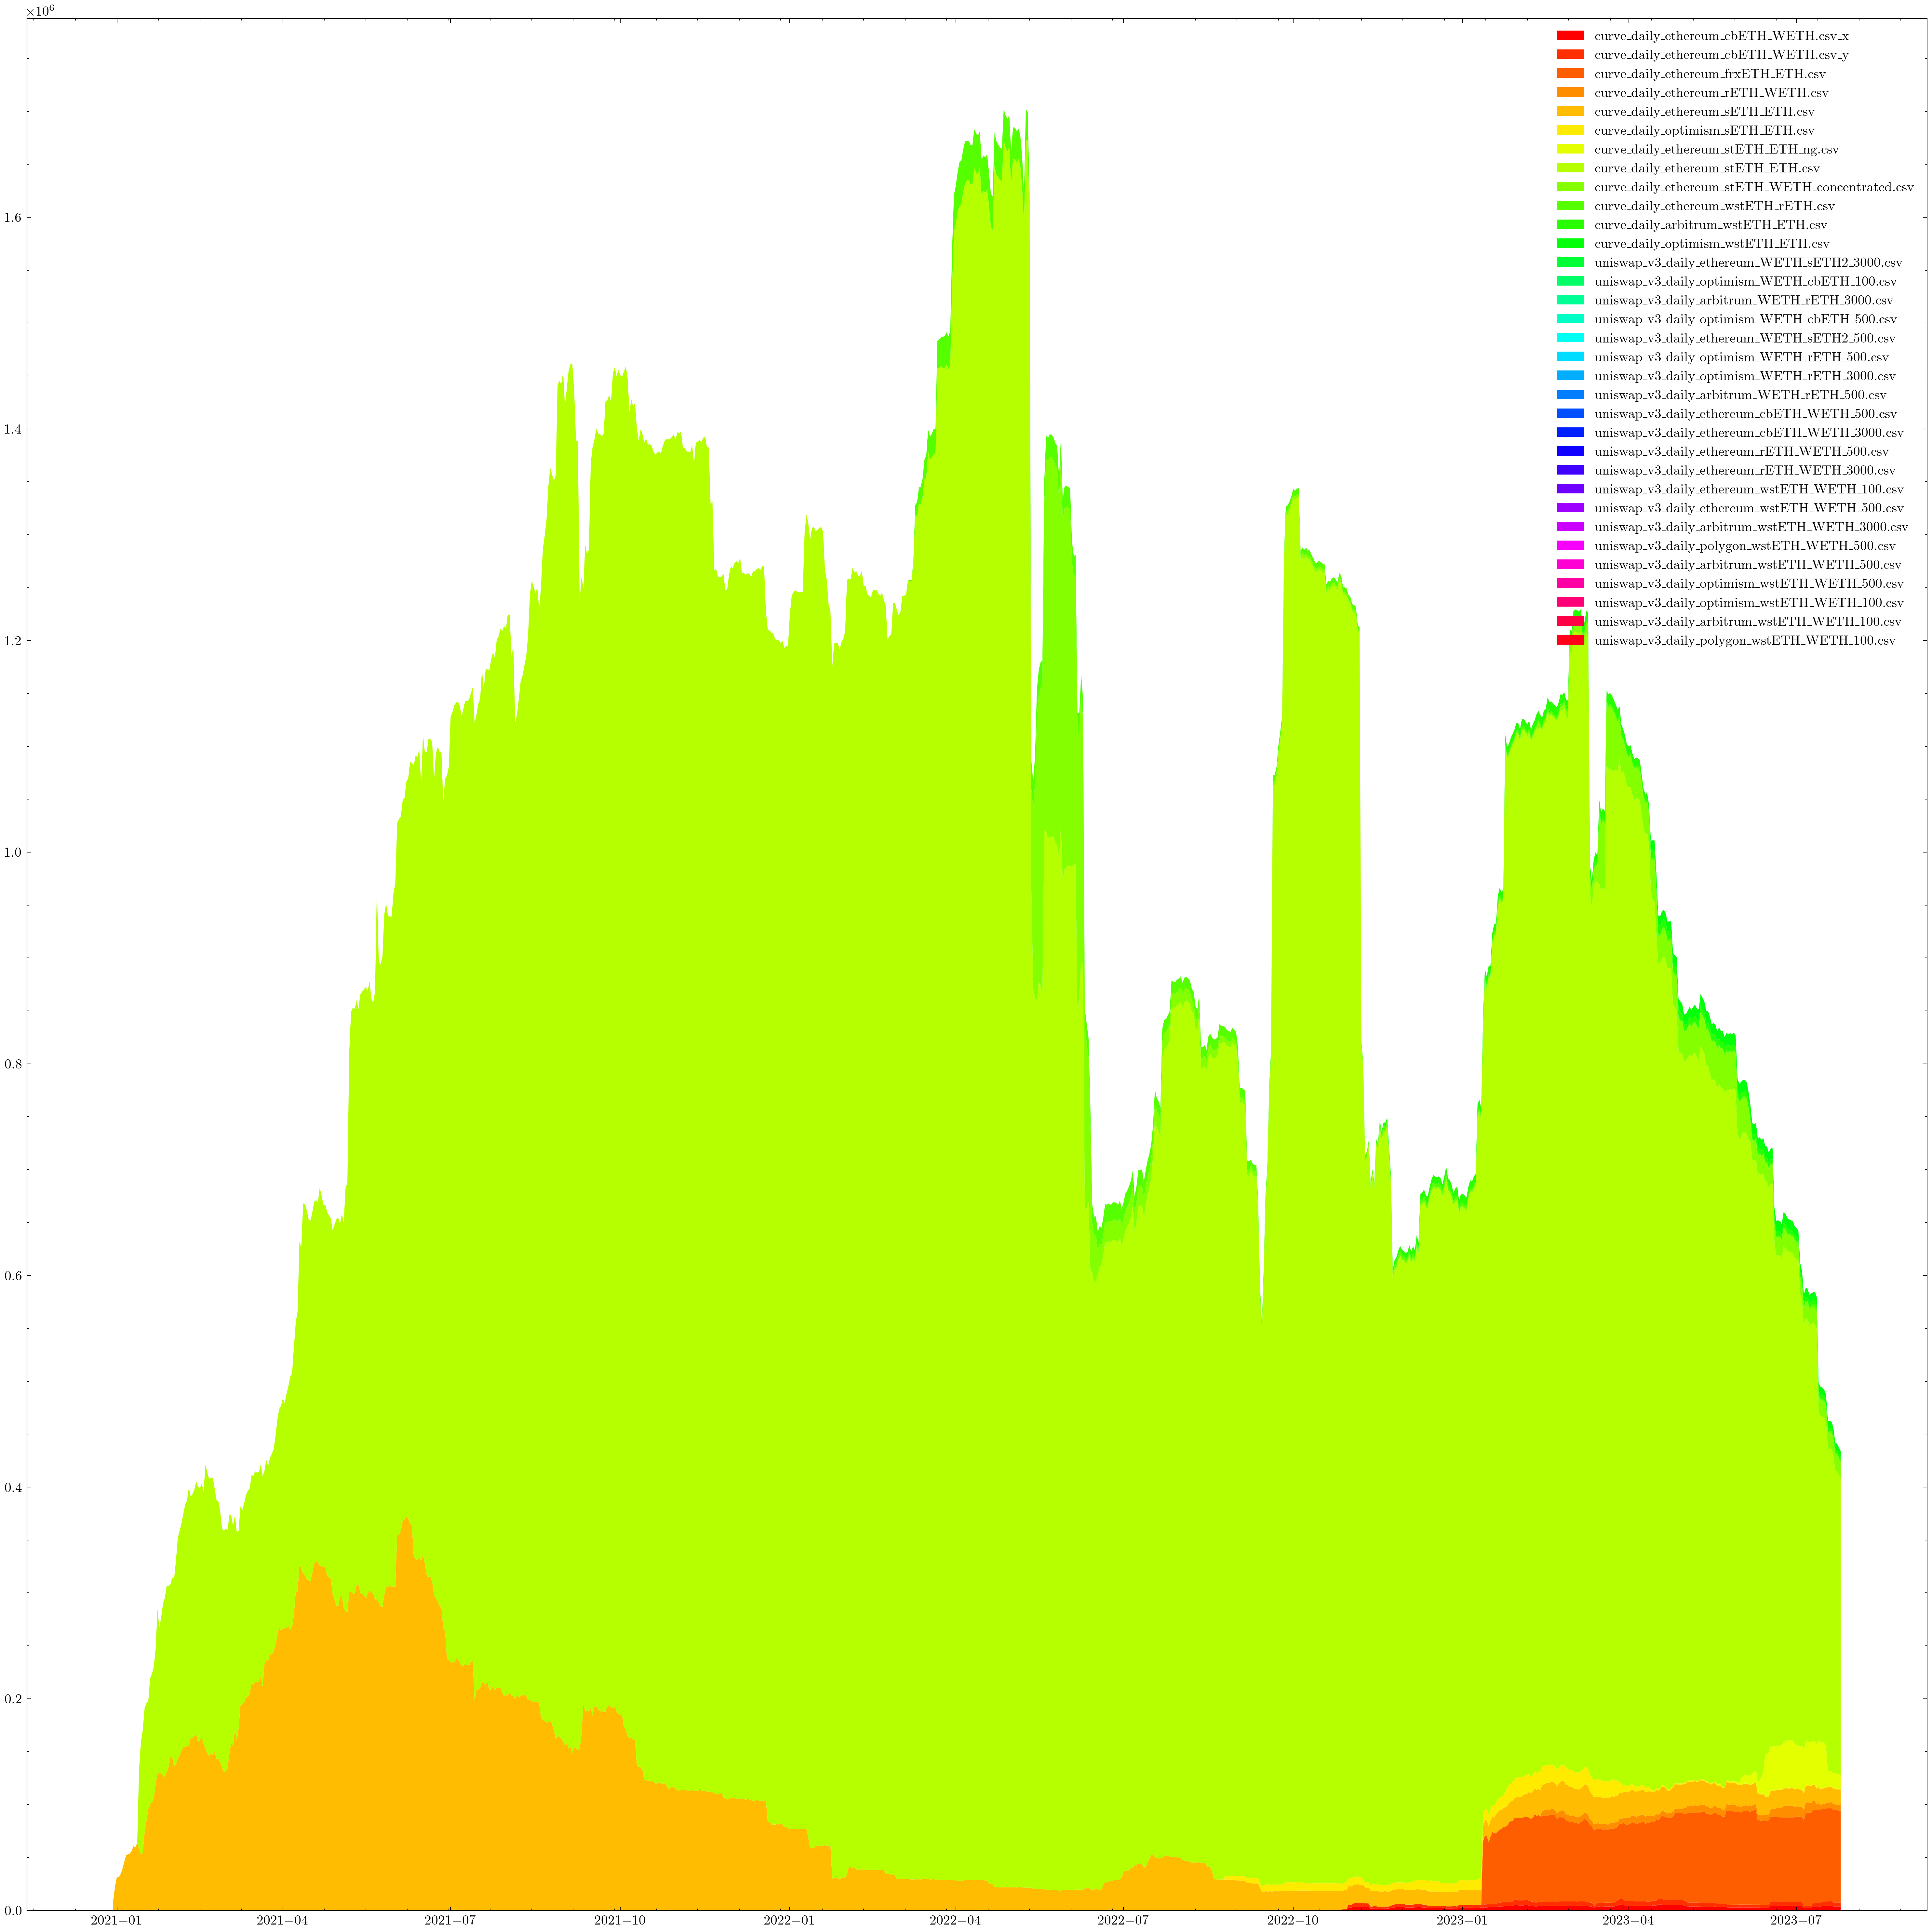

In [502]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,20),dpi =300)


import matplotlib as mpl

cmap = plt.get_cmap('hsv', 33)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]


ax.stackplot(df.index, stack, labels = labels, colors=custom_palette)
ax.legend()

#ax.set_title(df.filename)
#ax.set_ylabel('Price')
fig.set_facecolor('w')
fig.tight_layout()

In [371]:
tokens = []

for df in dfs:
    tokens.append(df.name_token0)
    tokens.append(df.name_token1)  

tokens = list(set(tokens))

In [372]:
print(tokens)

['sETH2', 'stETH', 'wstETH', 'sETH', 'cbETH', 'ETH', 'rETH', 'WETH', 'frxETH']


In [370]:
if 'alpha' in ['ALPHA'.lower()]:
    print('ok')

ok


In [358]:
'ALPHA'.lower()

'alpha'